
# SST neurons: ISI-based pre-AP vs baseline

Refined, class-focused pipeline to test whether sst interneurons depolarize before isolated spikes. Main steps:
1) Count APs per class in 2 s whisking windows (mean/std/n).
2) Use the median ISI of the chosen class as the "natural" pre-AP window length.
3) Extract isolated pre-AP Vm segments aligned to threshold, drop segments with early depolarization (configurable time band/mV limit).
4) Extract equally long baseline segments from quiet periods of the same class.
5) Compare pre-AP vs baseline Vm level/slope (distribution tests + time-resolved stats) to pinpoint when the pre-AP ramp becomes significant.

Set `target_class` (already set to SST) and run top-to-bottom.


In [1]:

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu, ttest_ind

plt.style.use("seaborn-v0_8-whitegrid")

# -----------------------------
# Paths (works whether run from repo root or notebooks/)
# -----------------------------
cwd = os.getcwd()
parts = cwd.split(os.sep)
if parts and parts[-1] == "notebooks":
    repo_root = os.path.dirname(cwd)
elif "notebooks" in parts:
    repo_root = os.sep.join(parts[:parts.index("notebooks")])
else:
    repo_root = cwd

scripts_dir = os.path.join(repo_root, "scripts")
if repo_root not in sys.path:
    sys.path.insert(1, repo_root)
if os.path.isdir(scripts_dir):
    init_file = os.path.join(scripts_dir, "__init__.py")
    if not os.path.exists(init_file):
        with open(init_file, "w", encoding="utf-8") as f:
            f.write("# package marker")

from scripts.helpers import Function_Detect_APs  # noqa: E402
from scripts.utils import remove_top_right_frame  # noqa: E402

# -----------------------------
# Load data
# -----------------------------
data_path = os.path.join(repo_root, "Data", "Data_bio482.pkl")
data_df = pd.read_pickle(data_path)
print("Data shape:", data_df.shape)
print("Cell types:", data_df.Cell_Type.unique())
print("Sweep types:", data_df.Sweep_Type.unique())


Data shape: (831, 24)
Cell types: ['EXC' 'PV' 'VIP' 'SST']
Sweep types: ['active touch' 'passive contact' 'free whisking']


In [2]:

# Analysis parameters
sweep_type = "free whisking"
target_class = "SST"  # change to EXC, SST, VIP to re-run
window_duration = 2.0  # s for AP counting
clean_window = (-0.013, -0.004)  # s relative to threshold to check for contamination
clean_thr_mV = -20.0  # mV threshold used to drop contaminated pre-AP segments


In [3]:

data_df_fw = data_df[data_df["Sweep_Type"] == sweep_type].copy()
print(f"Sweeps during {sweep_type}: {data_df_fw.shape[0]}")
print(data_df_fw.groupby("Cell_Type")["Cell_ID"].nunique())


Sweeps during free whisking: 497
Cell_Type
EXC    86
PV     49
SST    72
VIP    25
Name: Cell_ID, dtype: int64


In [4]:

def _normalize_epochs(epoch_array):
    """Return epochs as (N,2) array or None if invalid."""
    if not isinstance(epoch_array, np.ndarray):
        return None
    try:
        if np.isnan(epoch_array).all():
            return None
    except TypeError:
        pass
    if epoch_array.ndim == 2 and epoch_array.shape[1] == 2:
        return epoch_array
    if epoch_array.ndim == 1:
        if epoch_array.size == 2:
            return epoch_array.reshape(1, 2)
        if epoch_array.size % 2 == 0 and epoch_array.size > 0:
            return epoch_array.reshape(-1, 2)
    return None


def summarize_ap_counts(data_df, sweep_type="free whisking", window_duration=2.0):
    """Count APs in non-overlapping windows within whisking epochs for each class."""
    classes = ["EXC", "PV", "SST", "VIP"]
    counts_by_class = {cl: [] for cl in classes}

    for _, row in data_df[data_df["Sweep_Type"] == sweep_type].iterrows():
        cell_type = row["Cell_Type"]
        if cell_type not in counts_by_class:
            continue

        epochs = _normalize_epochs(row.get("Sweep_WhiskingTimes"))
        if epochs is None:
            continue

        vm = row["Sweep_MembranePotential"]
        sr_vm = row["Sweep_MembranePotential_SamplingRate"]
        ap_thresh = row["Cell_APThreshold_Slope"]
        ap_params = Function_Detect_APs(vm, sr_vm, ap_thresh)
        if ap_params is None or ap_params.size == 0:
            continue
        ap_peak_times = ap_params[:, 2]

        for t_start, t_end in epochs:
            n_win = int(np.floor((t_end - t_start) / window_duration))
            for k in range(n_win):
                w_start = t_start + k * window_duration
                w_end = w_start + window_duration
                n_spikes = np.sum((ap_peak_times >= w_start) & (ap_peak_times < w_end))
                counts_by_class[cell_type].append(n_spikes)

    summary_rows = []
    for cl in classes:
        counts = np.array(counts_by_class[cl])
        summary_rows.append({
            "Cell_Type": cl,
            "n_windows": counts.size,
            "mean_AP_per_window": np.mean(counts) if counts.size else np.nan,
            "std_AP_per_window": np.std(counts) if counts.size else np.nan,
        })

    summary_df = pd.DataFrame(summary_rows)
    return summary_df, counts_by_class


  Cell_Type  n_windows  mean_AP_per_window  std_AP_per_window
0       EXC        232            3.443966           6.616747
1        PV        109           76.935780          74.110168
2       SST        171           13.128655          15.878775
3       VIP        251           31.713147          23.448625


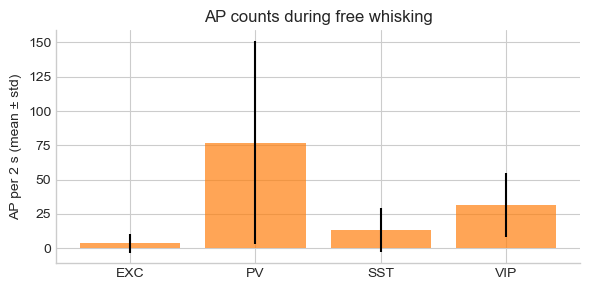

In [5]:

ap_summary_df, ap_counts = summarize_ap_counts(data_df, sweep_type=sweep_type, window_duration=window_duration)
print(ap_summary_df)

fig, ax = plt.subplots(figsize=(6, 3))
ax.bar(ap_summary_df["Cell_Type"], ap_summary_df["mean_AP_per_window"], yerr=ap_summary_df["std_AP_per_window"], color="C1", alpha=0.7)
ax.set_ylabel(f"AP per {window_duration:.0f} s (mean ± std)")
ax.set_title(f"AP counts during {sweep_type}")
try:
    remove_top_right_frame(ax)
except NameError:
    pass
plt.tight_layout()
plt.show()


In [6]:



def compute_isi_distribution(data_df, cell_type="PV", sweep_type="free whisking"):
    subset = data_df[(data_df["Cell_Type"] == cell_type) & (data_df["Sweep_Type"] == sweep_type)]
    all_isis = []

    for _, cell_df in subset.groupby("Cell_ID"):
        spike_times = []
        for _, row in cell_df.iterrows():
            vm = row["Sweep_MembranePotential"]
            sr_vm = row["Sweep_MembranePotential_SamplingRate"]
            ap_thresh = row["Cell_APThreshold_Slope"]
            ap_params = Function_Detect_APs(vm, sr_vm, ap_thresh)
            if ap_params is None or ap_params.size == 0:
                continue
            ap_params = ap_params[np.isfinite(ap_params[:, 0])]
            if ap_params.size == 0:
                continue
            spike_times.extend(ap_params[:, 0])  # threshold times
        spike_times = np.asarray(spike_times, dtype=float)
        spike_times = spike_times[np.isfinite(spike_times)]
        if spike_times.size < 2:
            continue
        spike_times.sort()
        isi = np.diff(spike_times)
        isi = isi[np.isfinite(isi)]
        if isi.size:
            all_isis.append(isi)

    if not all_isis:
        return np.array([]), np.nan

    all_isis = np.concatenate(all_isis)
    median_isi = float(np.median(all_isis))
    return all_isis, median_isi


SST: n ISIs = 35409, median = 0.0229 s


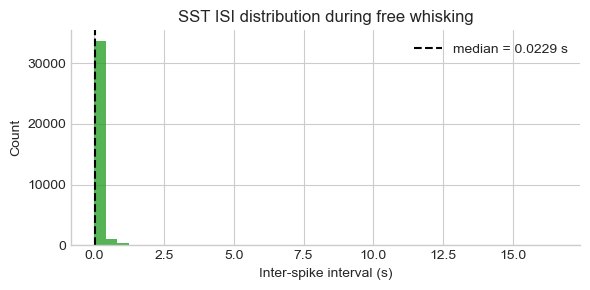

In [7]:

isis, median_isi = compute_isi_distribution(data_df, cell_type=target_class, sweep_type=sweep_type)
print(f"{target_class}: n ISIs = {len(isis)}, median = {median_isi:.4f} s")

if len(isis) > 0:
    fig, ax = plt.subplots(figsize=(6,3))
    ax.hist(isis, bins=40, color="C2", alpha=0.8)
    ax.axvline(median_isi, color="k", linestyle="--", label=f"median = {median_isi:.4f} s")
    ax.set_xlabel("Inter-spike interval (s)")
    ax.set_ylabel("Count")
    ax.set_title(f"{target_class} ISI distribution during {sweep_type}")
    ax.legend()
    try:
        remove_top_right_frame(ax)
    except NameError:
        pass
    plt.tight_layout()
    plt.show()


In [8]:



def collect_pre_ap_segments(data_df, cell_type="PV", sweep_type="free whisking", pre_window=None):
    if pre_window is None:
        _, pre_window = compute_isi_distribution(data_df, cell_type=cell_type, sweep_type=sweep_type)
        print(f"Using median ISI {pre_window:.4f} s as pre-window for {cell_type}")

    subset = data_df[(data_df["Cell_Type"] == cell_type) & (data_df["Sweep_Type"] == sweep_type)]
    segments = []
    cell_ids = []
    sr_vm_global = None

    for _, row in subset.iterrows():
        vm = row["Sweep_MembranePotential"]
        sr_vm = row["Sweep_MembranePotential_SamplingRate"]
        ap_thresh = row["Cell_APThreshold_Slope"]
        cell_id = row["Cell_ID"]

        if sr_vm_global is None:
            sr_vm_global = sr_vm
        elif sr_vm != sr_vm_global:
            continue

        ap_params = Function_Detect_APs(vm, sr_vm, ap_thresh)
        if ap_params is None or ap_params.size == 0:
            continue
        ap_params = ap_params[np.isfinite(ap_params[:, 0])]
        if ap_params.size == 0:
            continue

        thresh_times = np.sort(ap_params[:, 0])
        if thresh_times.size == 0:
            continue

        n_samples = int(pre_window * sr_vm)
        if n_samples <= 1:
            continue

        for i, t_th in enumerate(thresh_times):
            if t_th < pre_window:
                continue
            if i > 0 and (t_th - thresh_times[i - 1] < pre_window):
                continue

            end_idx = int(t_th * sr_vm)
            start_idx = end_idx - n_samples
            if start_idx < 0 or end_idx > len(vm):
                continue

            seg = vm[start_idx:end_idx]
            if seg.shape[0] != n_samples:
                continue

            segments.append(seg * 1000.0)
            cell_ids.append(cell_id)

    if len(segments) == 0:
        return None, None, sr_vm_global, pre_window, None

    segments = np.vstack(segments)
    cell_ids = np.array(cell_ids)
    finite_mask = ~np.isnan(segments).any(axis=1)
    segments = segments[finite_mask]
    cell_ids = cell_ids[finite_mask]

    if segments.size == 0:
        return None, None, sr_vm_global, pre_window, None

    t = np.linspace(-pre_window, 0, segments.shape[1], endpoint=False)
    return t, segments, sr_vm_global, pre_window, cell_ids


In [9]:

t_pre, seg_pre, sr_vm, pre_window_used, seg_cell_ids = collect_pre_ap_segments(
    data_df,
    cell_type=target_class,
    sweep_type=sweep_type,
    pre_window=median_isi if not np.isnan(median_isi) else None,
)

print(f"Segments collected: {None if seg_pre is None else seg_pre.shape}")


Segments collected: (24262, 457)


In [10]:



def filter_segments(segments, cell_ids, t, t_min=-0.013, t_max=-0.004, thr_mV=-20.0):
    if segments is None or cell_ids is None or t is None:
        return None, None, {}

    segments = np.asarray(segments)
    cell_ids = np.asarray(cell_ids)
    n_before = int(segments.shape[0])

    finite_mask = ~np.isnan(segments).any(axis=1)
    segments = segments[finite_mask]
    cell_ids = cell_ids[finite_mask]

    if segments.size == 0:
        return None, None, {
            "t_min": t_min,
            "t_max": t_max,
            "thr_mV": thr_mV,
            "n_segments_before": n_before,
            "n_segments_after": 0,
            "n_cells_before": int(len(np.unique(cell_ids))),
            "n_cells_after": 0,
            "n_segments_removed": n_before,
            "n_cells_removed": int(len(np.unique(cell_ids))),
        }

    time_mask = (t >= t_min) & (t <= t_max)
    sub_segments = segments[:, time_mask]
    keep_mask = np.max(sub_segments, axis=1) < thr_mV

    segments_filt = segments[keep_mask]
    cell_ids_filt = cell_ids[keep_mask]

    stats = {
        "t_min": t_min,
        "t_max": t_max,
        "thr_mV": thr_mV,
        "n_segments_before": n_before,
        "n_segments_after": int(segments_filt.shape[0]),
        "n_cells_before": int(len(np.unique(cell_ids))),
        "n_cells_after": int(len(np.unique(cell_ids_filt))),
    }
    stats["n_segments_removed"] = stats["n_segments_before"] - stats["n_segments_after"]
    stats["n_cells_removed"] = stats["n_cells_before"] - stats["n_cells_after"]
    return segments_filt, cell_ids_filt, stats


In [11]:

seg_pre_clean, seg_cell_ids_clean, clean_stats = filter_segments(
    seg_pre, seg_cell_ids, t_pre,
    t_min=clean_window[0], t_max=clean_window[1], thr_mV=clean_thr_mV,
)
print(clean_stats)


{'t_min': -0.013, 't_max': -0.004, 'thr_mV': -20.0, 'n_segments_before': 24262, 'n_segments_after': 24262, 'n_cells_before': 72, 'n_cells_after': 72, 'n_segments_removed': 0, 'n_cells_removed': 0}


In [12]:



def collect_baseline_segments(data_df, cell_type="PV", sweep_type="free whisking", window_length=0.02):
    subset = data_df[(data_df["Cell_Type"] == cell_type) & (data_df["Sweep_Type"] == sweep_type)]
    segments = []
    cell_ids = []
    sr_vm_global = None

    for _, row in subset.iterrows():
        quiet_times = row.get("Sweep_QuietTimes")
        if not isinstance(quiet_times, np.ndarray) or quiet_times.size == 0:
            continue

        vm = row["Sweep_MembranePotential"]
        sr_vm = row["Sweep_MembranePotential_SamplingRate"]
        cell_id = row["Cell_ID"]

        if sr_vm_global is None:
            sr_vm_global = sr_vm
        elif sr_vm != sr_vm_global:
            continue

        n_samples = int(window_length * sr_vm)
        if n_samples <= 1:
            continue

        for t_start, t_end in quiet_times:
            if (t_end - t_start) < window_length:
                continue
            start_times = np.arange(t_start, t_end - window_length + 1e-12, window_length)
            for st in start_times:
                start_idx = int(st * sr_vm)
                end_idx = start_idx + n_samples
                if end_idx > len(vm):
                    continue
                seg = vm[start_idx:end_idx] * 1000.0
                segments.append(seg)
                cell_ids.append(cell_id)

    if len(segments) == 0:
        return None, None, sr_vm_global

    segments = np.vstack(segments)
    cell_ids = np.array(cell_ids)
    finite_mask = ~np.isnan(segments).any(axis=1)
    segments = segments[finite_mask]
    cell_ids = cell_ids[finite_mask]

    if segments.size == 0:
        return None, None, sr_vm_global

    t = np.linspace(-window_length, 0, segments.shape[1], endpoint=False)
    return t, segments, cell_ids


In [13]:

t_baseline, seg_baseline, baseline_ids = collect_baseline_segments(
    data_df,
    cell_type=target_class,
    sweep_type=sweep_type,
    window_length=pre_window_used,
)
print(f"Baseline segments: {None if seg_baseline is None else seg_baseline.shape}")


Baseline segments: (175130, 457)


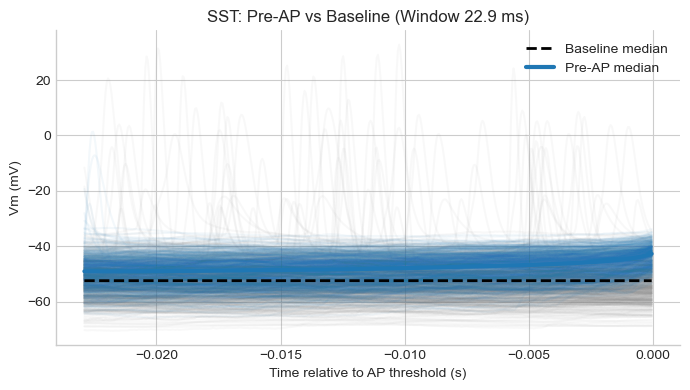

Vm mean comparison (Mann-Whitney): p = 0.000e+00, rank-biserial r = -0.404, Cohen's d = 0.683, median diff = 4.576 mV
Slope comparison (Mann-Whitney): p = 0.000e+00, rank-biserial r = -0.795, Cohen's d = 1.160, median diff = 259.018 mV/s


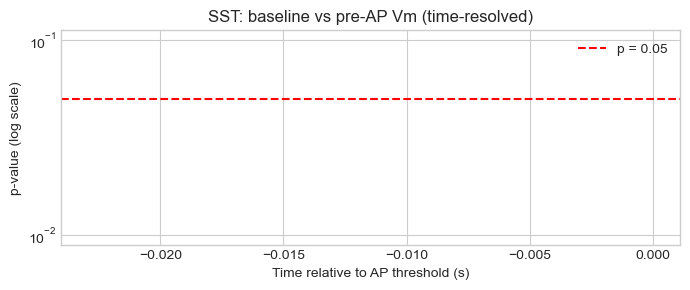

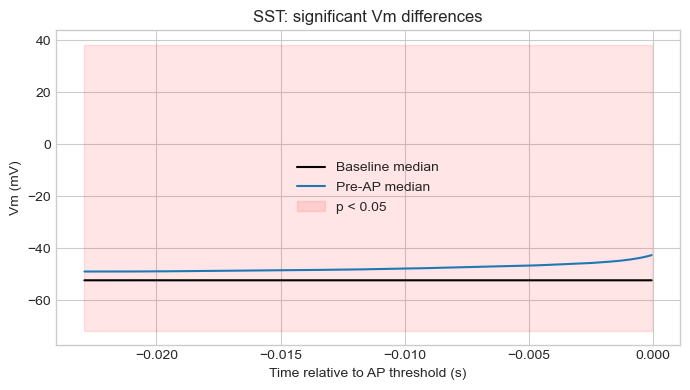

In [14]:



if seg_pre_clean is None or seg_baseline is None or seg_pre_clean.size == 0 or seg_baseline.size == 0:
    print("Not enough segments to compare.")
else:
    median_pre = np.median(seg_pre_clean, axis=0)
    median_base = np.median(seg_baseline, axis=0)
    dt = 1.0 / sr_vm
    slope_pre = np.gradient(seg_pre_clean, axis=1) / dt
    slope_base = np.gradient(seg_baseline, axis=1) / dt

    # 1) Visualization: downsample traces for plotting to avoid crashes.
    n_plot = 500
    fig, ax = plt.subplots(figsize=(7, 4))

    if seg_baseline.shape[0] > n_plot:
        idx_base = np.random.choice(seg_baseline.shape[0], n_plot, replace=False)
        for i in idx_base:
            ax.plot(t_baseline, seg_baseline[i], color="gray", alpha=0.05)
    else:
        for trace in seg_baseline:
            ax.plot(t_baseline, trace, color="gray", alpha=0.05)

    if seg_pre_clean.shape[0] > n_plot:
        idx_pre = np.random.choice(seg_pre_clean.shape[0], n_plot, replace=False)
        for i in idx_pre:
            ax.plot(t_pre, seg_pre_clean[i], color="tab:blue", alpha=0.05)
    else:
        for trace in seg_pre_clean:
            ax.plot(t_pre, trace, color="tab:blue", alpha=0.05)

    ax.plot(t_baseline, median_base, color="black", linewidth=2, linestyle="--", label="Baseline median")
    ax.plot(t_pre, median_pre, color="tab:blue", linewidth=3, label="Pre-AP median")
    ax.set_xlabel("Time relative to AP threshold (s)")
    ax.set_ylabel("Vm (mV)")
    ax.set_title(f"{target_class}: Pre-AP vs Baseline (Window {pre_window_used*1000:.1f} ms)")
    ax.legend()
    try:
        remove_top_right_frame(ax)
    except NameError:
        pass
    plt.tight_layout()
    plt.show()

    def cohens_d(x, y):
        x = np.asarray(x)
        y = np.asarray(y)
        nx, ny = len(x), len(y)
        if nx < 2 or ny < 2:
            return np.nan
        dof = nx + ny - 2
        pooled = (((nx - 1) * np.var(x, ddof=1)) + ((ny - 1) * np.var(y, ddof=1))) / dof
        return (np.mean(x) - np.mean(y)) / np.sqrt(pooled)

    baseline_values = np.mean(seg_baseline, axis=1)
    pre_values = np.mean(seg_pre_clean, axis=1)
    vm_stat, vm_p = mannwhitneyu(baseline_values, pre_values, alternative="two-sided")
    vm_rbc = (2 * vm_stat) / (baseline_values.size * pre_values.size) - 1
    vm_d = cohens_d(pre_values, baseline_values)
    vm_median_delta = np.median(pre_values) - np.median(baseline_values)
    print(f"Vm mean comparison (Mann-Whitney): p = {vm_p:.3e}, rank-biserial r = {vm_rbc:.3f}, Cohen's d = {vm_d:.3f}, median diff = {vm_median_delta:.3f} mV")

    baseline_slopes = np.mean(slope_base, axis=1)
    pre_slopes = np.mean(slope_pre, axis=1)
    slope_stat, slope_p = mannwhitneyu(baseline_slopes, pre_slopes, alternative="two-sided")
    slope_rbc = (2 * slope_stat) / (baseline_slopes.size * pre_slopes.size) - 1
    slope_d = cohens_d(pre_slopes, baseline_slopes)
    slope_median_delta = np.median(pre_slopes) - np.median(baseline_slopes)
    print(f"Slope comparison (Mann-Whitney): p = {slope_p:.3e}, rank-biserial r = {slope_rbc:.3f}, Cohen's d = {slope_d:.3f}, median diff = {slope_median_delta:.3f} mV/s")

    pvals = []
    for i in range(seg_baseline.shape[1]):
        pvals.append(ttest_ind(seg_baseline[:, i], seg_pre_clean[:, i], equal_var=False).pvalue)
    pvals = np.array(pvals)
    sig_mask = pvals < 0.05

    fig, ax = plt.subplots(figsize=(7, 3))
    ax.plot(t_pre, pvals, color="purple")
    ax.axhline(0.05, color="red", linestyle="--", label="p = 0.05")
    ax.set_yscale("log")
    ax.set_xlabel("Time relative to AP threshold (s)")
    ax.set_ylabel("p-value (log scale)")
    ax.set_title(f"{target_class}: baseline vs pre-AP Vm (time-resolved)")
    ax.legend()
    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(figsize=(7, 4))
    ax.plot(t_pre, median_base, color="black", label="Baseline median")
    ax.plot(t_pre, median_pre, color="tab:blue", label="Pre-AP median")
    ax.fill_between(t_pre, np.min(seg_pre_clean), np.max(seg_pre_clean), where=sig_mask, color="red", alpha=0.1, label="p < 0.05")
    ax.set_xlabel("Time relative to AP threshold (s)")
    ax.set_ylabel("Vm (mV)")
    ax.set_title(f"{target_class}: significant Vm differences")
    ax.legend()
    plt.tight_layout()
    plt.show()
